In [1]:
from model import *
from baseline import Baseline
import networkx as nx
from metrics import *
import matplotlib.pyplot as plt

In [17]:
NUMBER_OF_SAMPLES = 1000

In [18]:
def remove_isolated_nodes(graphs):
    for graph in graphs:
        graph.remove_nodes_from(list(nx.isolates(graph)))

In [19]:
datamodule = TUDataMoudle()
datamodule.setup("fit")
training_batch = next(iter(datamodule.train_dataloader())) 
adjesency_matrixes = to_dense_adj(training_batch.edge_index, training_batch.batch)
training_samples = [nx.from_numpy_array(adjesency_matrix.detach().numpy()) for adjesency_matrix in adjesency_matrixes]

remove_isolated_nodes(training_samples)

In [93]:
model = VAE.load_from_checkpoint("model.ckpt")
baseline = Baseline(training_samples)

In [94]:
generated_samples = [nx.from_numpy_array(adjesency_matrix.cpu().detach().numpy()) for adjesency_matrix in model.sample(NUMBER_OF_SAMPLES)]
remove_isolated_nodes(generated_samples)

baseline_samples = baseline.sample(NUMBER_OF_SAMPLES)

In [95]:
def plot_histogram(training_samples, baseline_samples, generated_samples, title, histogram_function, bins=10):
    training_data, baseline_data, generated_data = histogram_function(training_samples), histogram_function(baseline_samples), histogram_function(generated_samples)
   
    # Increase the width of the figure
    plt.figure(figsize=(20, 5))  
    plt.suptitle(title, fontsize=16)

    # Create the first subplot and specify it to share its y-axis
    ax1 = plt.subplot(1, 3, 1)
    plt.hist(training_data, weights=[1/len(training_samples)]*len(training_data), bins=bins)
    plt.title("Training data", fontsize=12)
    
    # Create the second subplot, sharing the y-axis with the first subplot
    ax2 = plt.subplot(1, 3, 2, sharey=ax1)
    plt.hist(baseline_data, weights=[1/len(baseline_samples)]*len(baseline_data), bins=bins)
    plt.title("Baseline data", fontsize=12)
    plt.setp(ax2.get_yticklabels(), visible=False)  # Optionally hide y-axis labels for shared axis

    # Create the third subplot, sharing the y-axis with the first subplot
    ax3 = plt.subplot(1, 3, 3, sharey=ax1)
    plt.hist(generated_data, weights=[1/len(generated_samples)]*len(generated_data), bins=bins)
    plt.title("Generated data", fontsize=12)
    plt.setp(ax3.get_yticklabels(), visible=False)  # Optionally hide y-axis labels for shared axis
    
    # Apply tight layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot


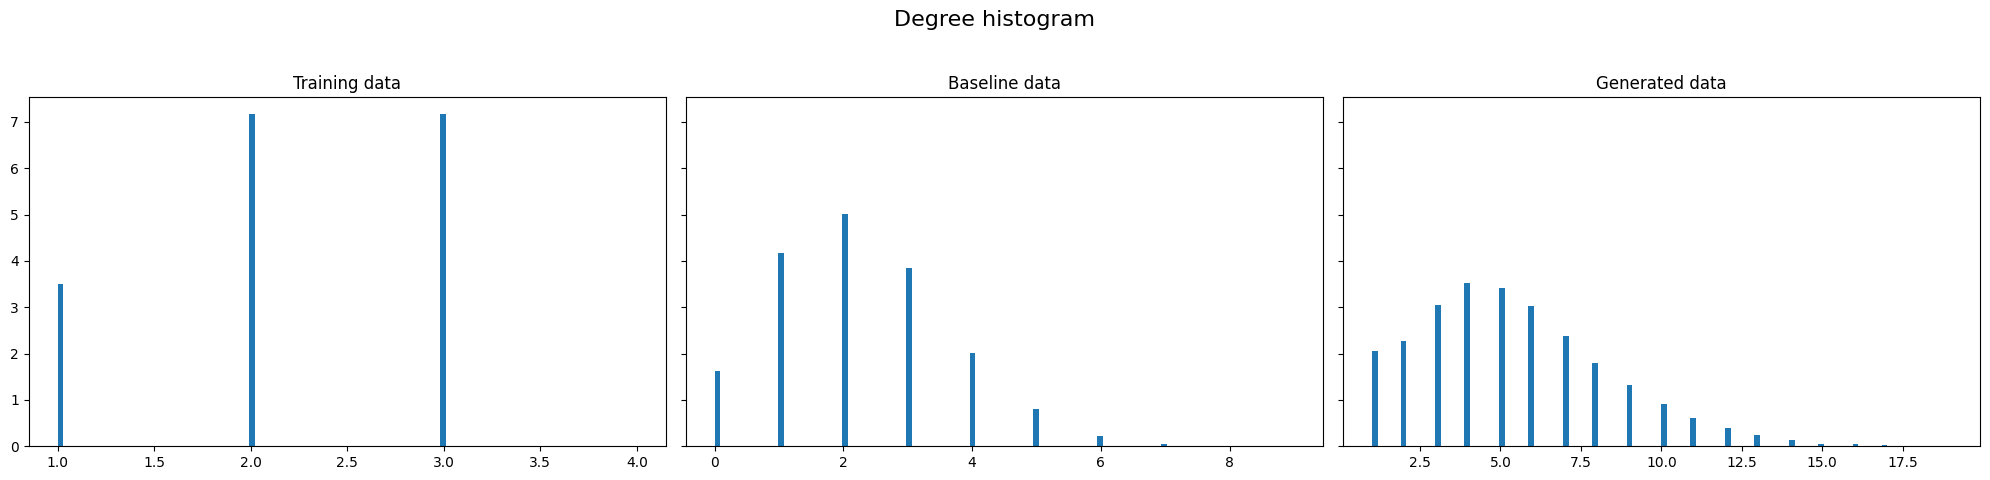

In [96]:
plot_histogram(training_samples, baseline_samples, generated_samples, "Degree histogram", degree_histogram, 100 )

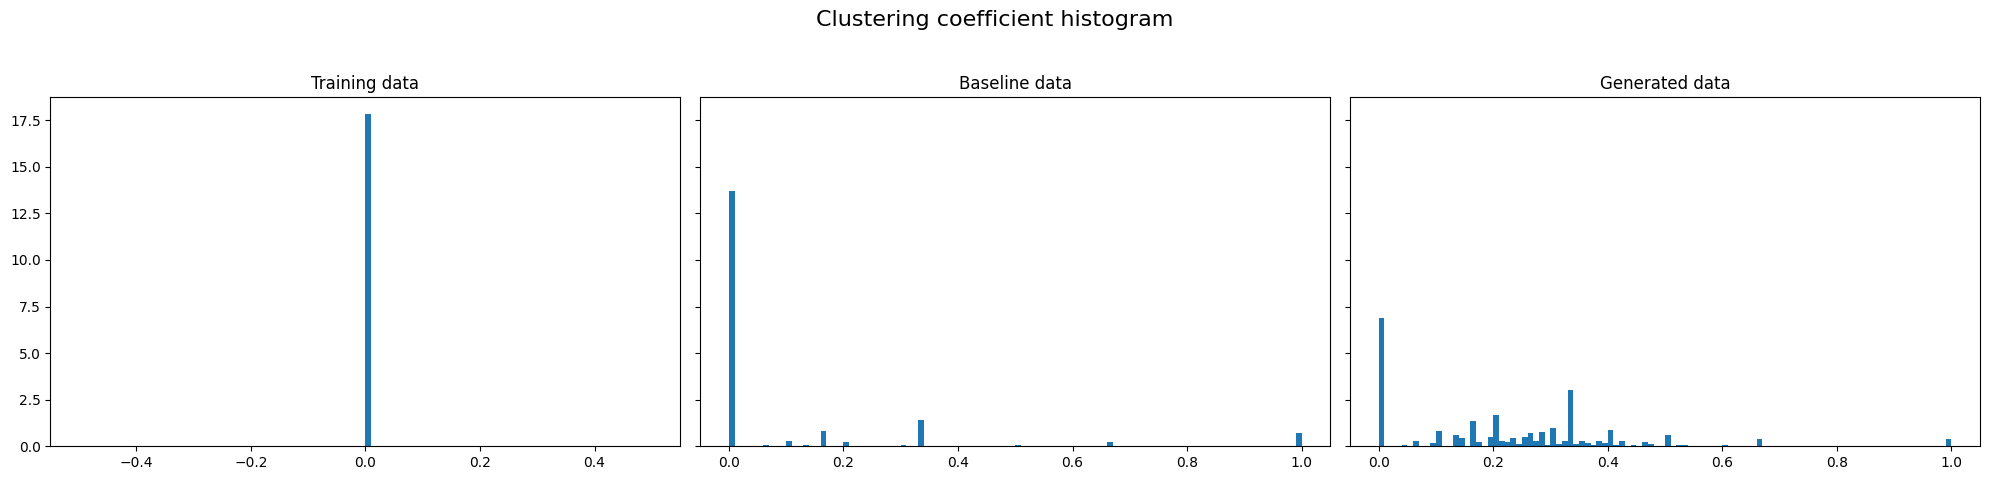

In [97]:
plot_histogram(training_samples, baseline_samples, generated_samples, "Clustering coefficient histogram", clustering_coefficient_histogram,100 )

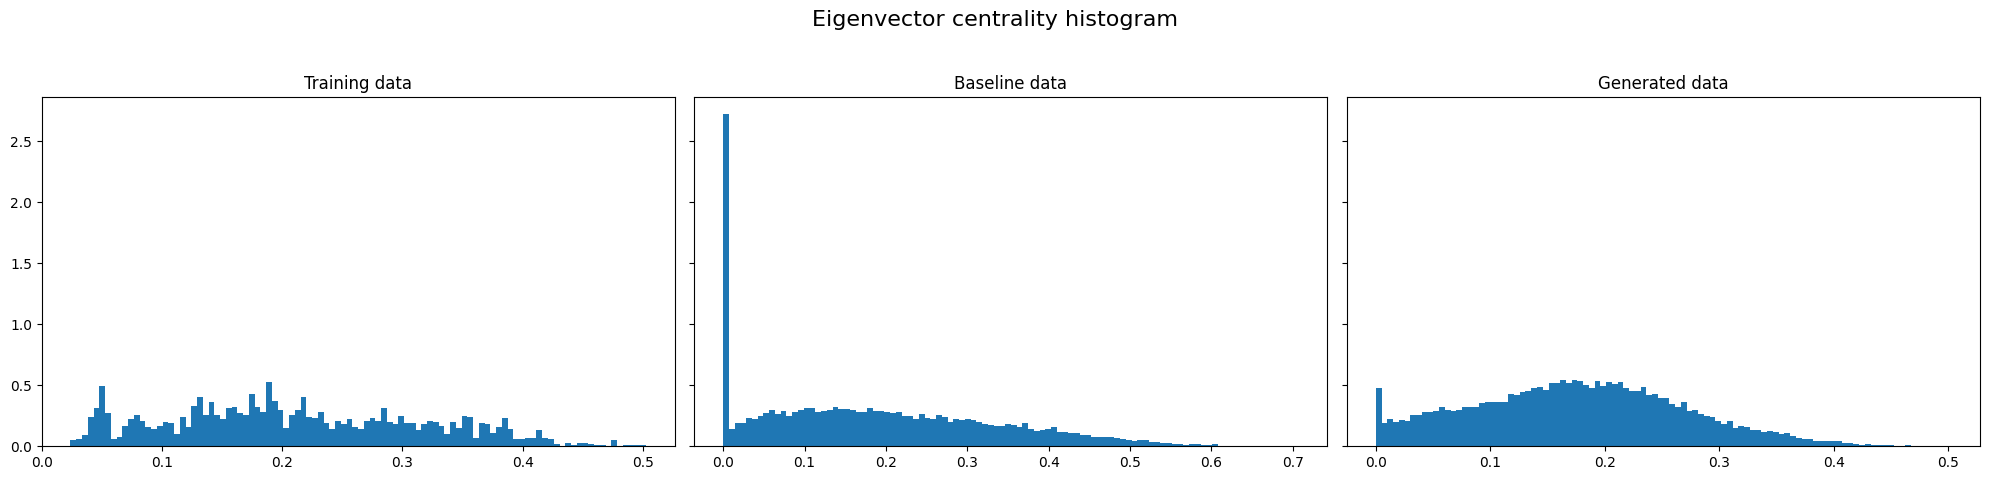

In [98]:
plot_histogram(training_samples, baseline_samples, generated_samples, "Eigenvector centrality histogram", eigenvector_centrality_histogram, 100 )

In [99]:
generated_novelty = novel(generated_samples, training_samples)
generated_uniqnes = unique(generated_samples)

print("Generated novelty: ", generated_novelty)
print("Generated uniqnes: ", generated_uniqnes)

baseline_novelty = novel(baseline_samples, training_samples)
baseline_uniqnes = unique(baseline_samples)

print("Baseline novelty: ", baseline_novelty)
print("Baseline uniqnes: ", baseline_uniqnes)


Generated novelty:  1.0
Generated uniqnes:  1.0
Baseline novelty:  1.0
Baseline uniqnes:  0.998


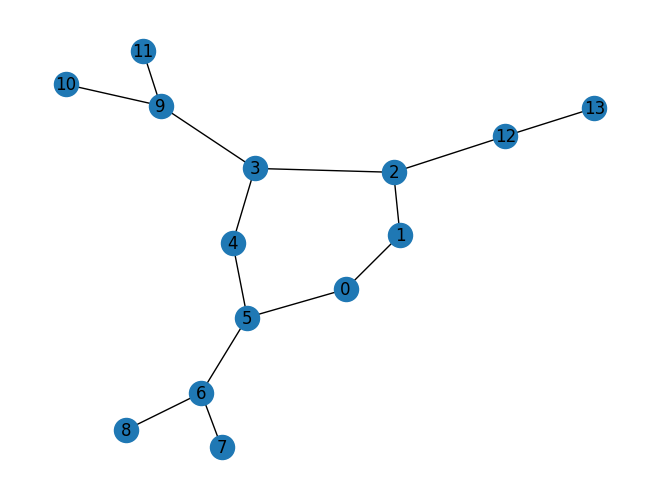

In [100]:
nx.draw(training_samples[0], with_labels=True)

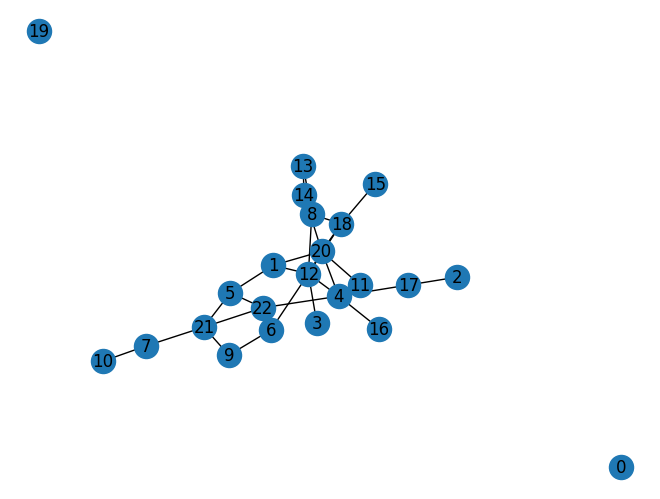

In [101]:
nx.draw(baseline_samples[0], with_labels=True)

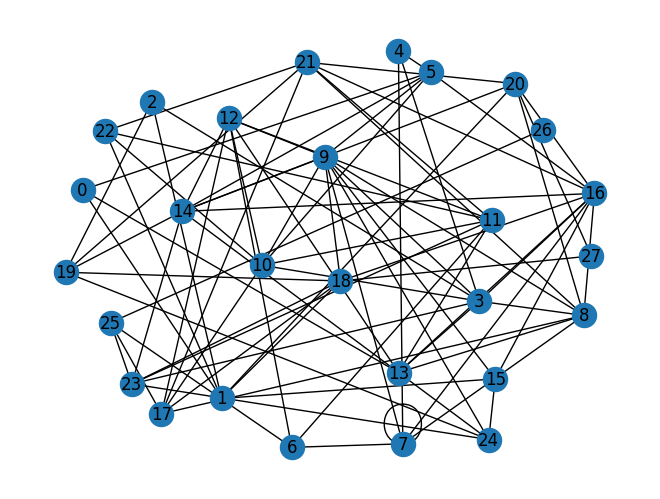

In [102]:
nx.draw(generated_samples[1], with_labels=True, pos=nx.spring_layout(generated_samples[1], k=2))


In [103]:
from einops import rearrange
prior = GaussianPrior(32)

model.to('cpu')
bernoulli_distribution = model.decoder(prior().sample(torch.tensor([1])))

# Accessing the Bernoulli distribution inside the Independent wrapper
internal_bernoulli = bernoulli_distribution.base_dist

# Accessing logits directly
retrieved_logits = internal_bernoulli.logits

# Converting logits to probabilities
probs = torch.sigmoid(retrieved_logits)
probs = rearrange(probs, 'b (c n) -> b c n', c=28)

print(probs)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7 and 32x128)